In [87]:
from datetime import datetime, timedelta
from IPython.display import clear_output
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [2]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [37]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="max")

In [38]:
s = time.time()
# data = get_data(get_all_tickers())
data = get_data("BA")
data_cop = data.copy()
print(time.time() - s)

[*********************100%***********************]  1 of 1 completed
0.9495415687561035


### Strategy and more shit

### Parsing initial dataframe

In [139]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Low", "Open", "Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["High"].rolling(window_size).max()
    df["doh"] = np.datetime64("1700-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [140]:
def strategy(parsed_data):
    df = parsed_data.copy()

    time_thresh1 = datetime.now() - timedelta(days=75)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = datetime.now() - timedelta(days=200)  
    
    # Buy signal
    buy_cond = df["High"] > df["High52"].shift()
    buy_cond2 = (df.index - df["doh"] < time_thresh2)
    df.loc[buy_cond, "Strategy"] = 1 
    
    # Sell cond- sell after 3 days, just for testing because I don't know yet how I should do it
    sell_cond = df["Strategy"].shift(3) == 1
    df.loc[sell_cond, "Strategy"] = -1
    
    # Position
    df.loc[df['Strategy'] == 1, 'pos'] = 1
    df.loc[df['Strategy'] == -1, 'pos'] = 0
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
    
    return df


df = strategy(parse_data(data_cop))

TypeError: Invalid comparison between dtype=timedelta64[ns] and datetime

In [ ]:
df["pos"].value_counts()

<Axes: xlabel='Date'>

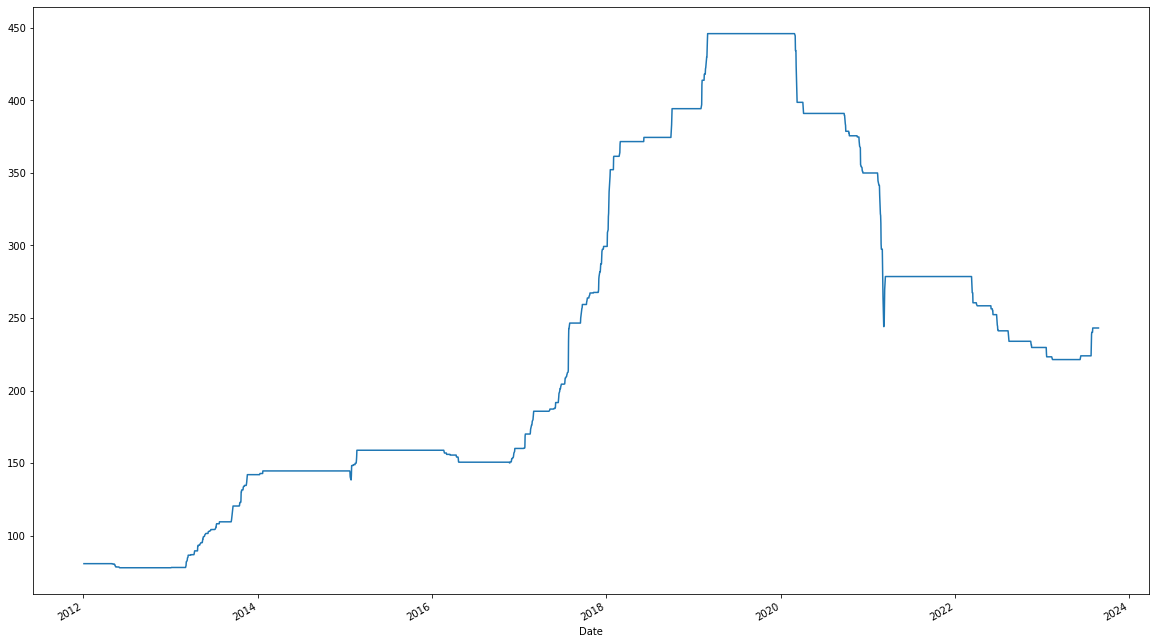

In [95]:
df['2012-01-01':'2023-12-31']["High52"].plot(figsize=(20,12))

In [121]:
df[270:290]

,High,Close,Volume,High52,doh,Strategy,pos
Date,,,,,,,
1963-01-28,0.64,0.64,984150,0.93,None,0,NaN
1963-01-29,0.64,0.63,528525,0.93,None,0,NaN
1963-01-30,0.64,0.63,461700,0.93,None,0,NaN
1963-01-31,0.64,0.64,656100,0.93,None,0,NaN
1963-02-01,0.66,0.66,643950,0.93,1963-02-01 00:00:00,0,NaN
1963-02-04,0.66,0.65,959850,0.93,1963-02-01 00:00:00,0,NaN
1963-02-05,0.65,0.65,376650,0.93,1963-02-01 00:00:00,0,NaN
1963-02-06,0.65,0.64,346275,0.93,1963-02-01 00:00:00,0,NaN
1963-02-07,0.65,0.65,285525,0.93,1963-02-01 00:00:00,0,NaN


In [110]:
df["doh"].value_counts()

1963-02-01    1
2005-04-05    1
2005-03-15    1
2005-03-04    1
2005-03-03    1
             ..
1982-11-02    1
1982-10-27    1
1982-10-22    1
1982-10-21    1
2023-08-01    1
Name: doh, Length: 1313, dtype: int64

In [118]:
df.loc["1963-02-15"]["High52"]

0.9218109846115112

In [138]:
# type(pd.Timestamp("1700-01-01", "ns"))
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex